### Imports

In [18]:
!pip install colorblind
import numpy as np
from colorblind import colorblind
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import img_as_ubyte
import cv2
import sys
from skimage import data, io, color
from PIL import Image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
#@title Lib
import numpy as np

from skimage import data, io, color
 
def rgb_to_lms_lib(img):
    lms_matrix = np.array(
        [[0.3904725 , 0.54990437, 0.00890159],
        [0.07092586, 0.96310739, 0.00135809],
        [0.02314268, 0.12801221, 0.93605194]]
        )
    return np.tensordot(img, lms_matrix, axes=([2], [1]))

def lms_to_rgb_lib(img):
    rgb_matrix = np.array(
        [[ 2.85831110e+00, -1.62870796e+00, -2.48186967e-02],
        [-2.10434776e-01,  1.15841493e+00,  3.20463334e-04],
        [-4.18895045e-02, -1.18154333e-01,  1.06888657e+00]]
        )
    return np.tensordot(img, rgb_matrix, axes=([2], [1]))

def simulate_colorblindness_lib(img, colorblind_type):
    #using the RGB-to-LMS matrix, data is transformed into the LMS space.
    lms_img = rgb_to_lms_lib(img)
    #deletion of the information corresponding to one of the cone types
    if colorblind_type.lower() in ['protanopia', 'p', 'pro']:
        sim_matrix = np.array([[0, 0.90822864, 0.008192], [0, 1, 0], [0, 0, 1]], dtype=np.float16)
    elif colorblind_type.lower() in ['deuteranopia', 'd', 'deut']:
        sim_matrix =  np.array([[1, 0, 0], [1.10104433,  0, -0.00901975], [0, 0, 1]], dtype=np.float16)
    elif colorblind_type.lower() in ['tritanopia', 't', 'tri']:
        sim_matrix = np.array([[1, 0, 0], [0, 1, 0], [-0.15773032,  1.19465634, 0]], dtype=np.float16)
    else:
        raise ValueError('{} is an unrecognized colorblindness type.'.format(colorblind_type))
    # matrix multiply
    lms_img = np.tensordot(lms_img, sim_matrix, axes=([2], [1]))
    # return back to rgb space with inverse transform.
    rgb_img = lms_to_rgb_lib(lms_img)
    # let's save the image as a colorblind person "should" see it
    io.imsave("asColorBlind.jpg",rgb_img.astype('uint8'))
    return rgb_img.astype(np.uint8)

def daltonize_correct_lib(img, colorblind_type):
    colorblind_img = simulate_colorblindness_lib(img, colorblind_type=colorblind_type)
    # error matrix is the difference between the original img and the simulated one
    error_matrix = img - colorblind_img
    # let's save this "error" trace
    io.imsave("errorImg.jpg",error_matrix.astype('uint8'))
    # correction with linear trans. to convey info to the colorblind person
    # done by mapping to the other side of the spectrum
    correction_matrix = np.array(
            [[0.0, 0.0, 0.0],
            [0.7, 1.0, 0.0],
            [0.7, 0.0, 1.0]]
            )
    # rotates this to a part of the spectrum that they can sees
    corrected_error_matrix = np.tensordot(error_matrix, correction_matrix, axes=([2], [1]))
    # let's save the highlight mask
    io.imsave("correctedErrorImg.jpg",corrected_error_matrix.astype('uint8'))
    # add the correction (highlight mask) to the image
    final = img + corrected_error_matrix
    np.set_printoptions(threshold=sys.maxsize)

    # Steps
    nImages = 7
    plt.figure(figsize=(30, 30))
    plt.subplot(1,nImages,1)
    plt.imshow(img.astype('uint8'))
    for x in range(2,nImages+1):
      img += (corrected_error_matrix / nImages).astype('uint8')
      plt.subplot(1,nImages,x)
      plt.imshow(img.astype('uint8'))

    return final

# **Daltonizing remarks & methods**

### **Autore**: Lorenzo Foschi

### **Goals**: The primary goal of this notebook is exploring different daltonizing methods, in order to understand the main concepts behind the treatment of images in the colorblind domain. The notebook is divided in four parts, that highlight different approaches:

### **Goal 1**: In the first part we use the colorblind library to observe the results and we use the information learned to make some remarks

### **Goal 2**: In the second part we give a closer look at the modules and we try to solve some problems in the usage of the library

### **Goal 3**: In the third part we give a look at a different, and improved, daltonizing method. We implement the first part of the pipeline, obtaining an interesting middle result.

### **Goal 4**: In the fourth part we move to a more abstract domain, looking at some advanced and physiological views of the daltonizing problem

## **GOAL 1**:

**Let's first see what being colorblind really means**:

Color vision is achieved through the L, M and S cones in the human retina. These
photosensitive receptors are sensitive to the long, middle and short wavelength ranges
of the visible spectrum, respectively. Color blindness is the result of a deficiency of
one (or more) of these photoreceptors. There are three typical kinds of color-blindness:
protanopic, deuteranopic, and tritanopic, which correspond to the deficiency of the L
cone, M cone, and S cone. These people have problem perceiving the full spectrum of
colors normal people can distinguish. 

*Let's comment a brief description of the daltonizing method, exploding it into two separate modules*:

**def simulate_colorblindness**

**1)** Find the LMS values of the RGB
(red-green-blue) image, using some conversion matrix commonly used in the literature. The LMS values correspond to what is received at the level of the retina. RGB, on
the other hand, corresponds to the phosphor levels on a cathode ray tube screen to
match the colors, and is used to define digital images.


---


**2)**  Make a
conversion to delete the information associated with the loss of any of the cone types to
get the modified LMS values L'M'S'

---


**3)**  Make a reverse transformation on the
L’M’S’ values to get the R’G’B’ values.  R’G’B’ presumably represent how that specific
color RGB is perceived by a color blind person. When this operation is done for all the
pixels, the image is converted.

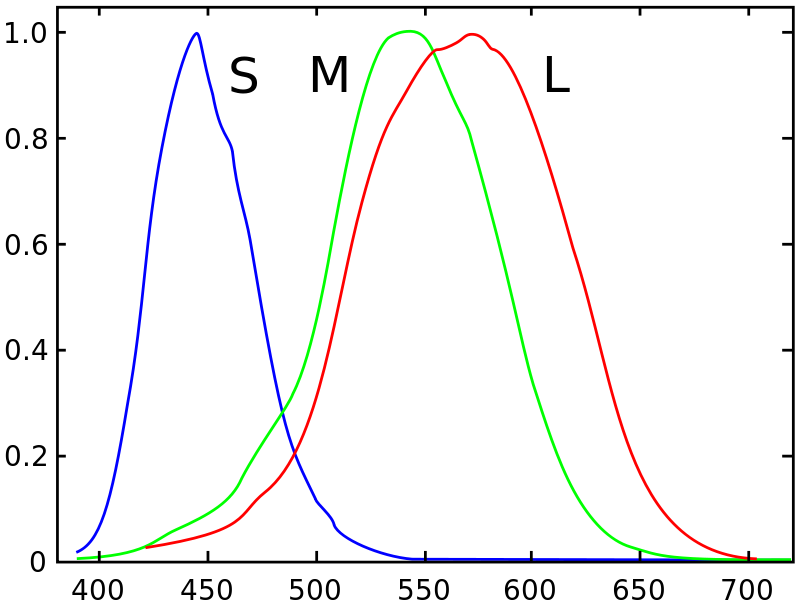

**def daltonize_correct**

**1)** Generate asColorBlind with simulate_colorblindness



---


**2)** Error matrix: the difference between the original img and the simulated one, so the image with R’G’B’ values subtracted from the original image. This represents the
information lost during the transformation. In other words the error picture is what
cannot be conveyed to a color blind person.



---


**3)** We make a linear transformation on this
picture so that it can be conveyed, and add this on the original picture to find the
daltonized image. For example, if the L cone is missing (protanope) the person will
have difficulty in seeing the red part of the spectrum. Consequently, in the simulation,
the error picture will consist of red shades mostly. Our transformation maps this
information to the blue side of the spectrum. When this is added on the original picture
we will get a daltonized version. The visibility of this image, therefore, is increased for
a protanope. 

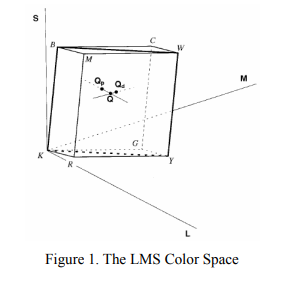

For a normal person, the color space spans over the KBMRGCWY 
parallelepiped. For a protanope, all the colors which are on QpQ line will appear the 
same, which is the intersection color of QpQ and KBWY plane.

**Let's now use the library to obtain different results**:

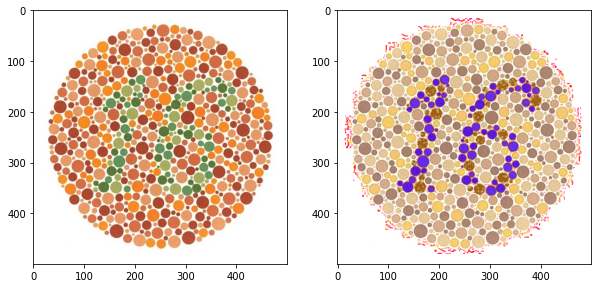

In [20]:
# load image
img0 = cv2.imread("ishihara.jpg")
img0 = img0[..., ::-1]

plt.figure(figsize=(10, 10))

plt.subplot(1,2,1)
plt.imshow(img0.astype('uint8'))

# correct using daltonization
daltonized_img0 = colorblind.daltonize_correct(img0, colorblind_type='p')

plt.subplot(1,2,2)
plt.imshow(daltonized_img0.astype('uint8'))

*As a protanope... now i see the "16"!*

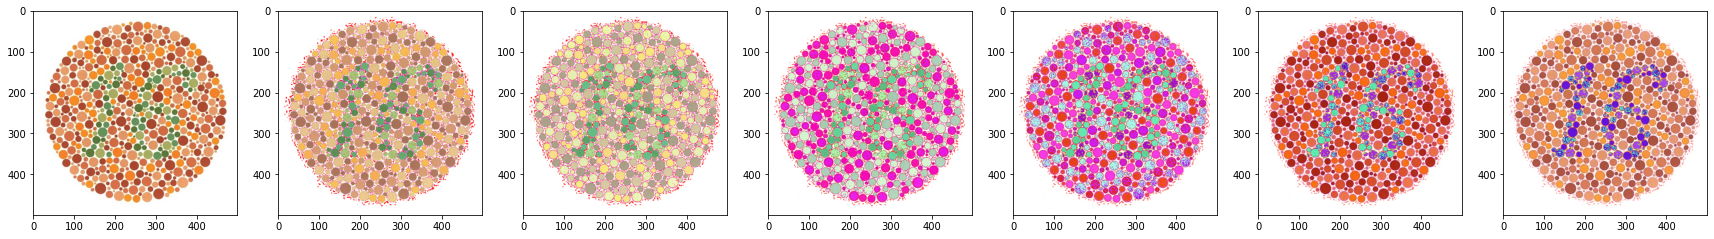

In [ ]:
# correct using daltonization
daltonized_img0 = daltonize_correct_lib(img0, colorblind_type='p')

*As a protanope... i see the "16" popping up incrementally!*

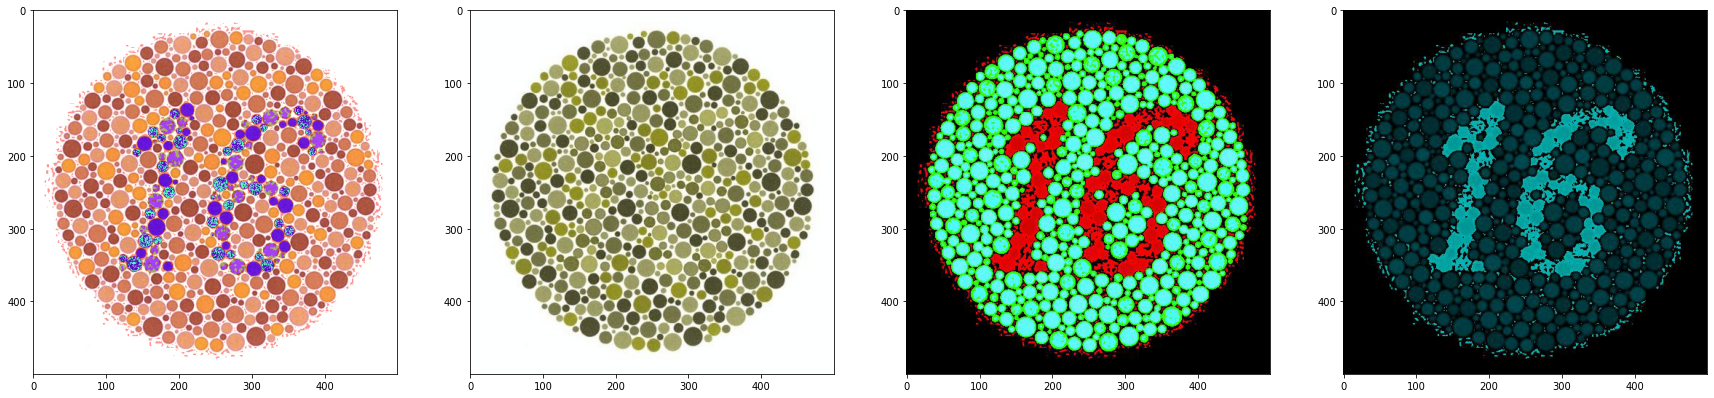

In [ ]:
asColorBlind = plt.imread("asColorBlind.jpg")
errorImg = plt.imread("errorImg.jpg")
correctedErrorImg = plt.imread("correctedErrorImg.jpg")
plt.figure(figsize=(30, 30))
plt.subplot(1,4,1)
plt.imshow(img0)
plt.subplot(1,4,2)
plt.imshow(asColorBlind)
plt.subplot(1,4,3)
plt.imshow(errorImg)
plt.subplot(1,4,4)
plt.imshow(correctedErrorImg)

### **Commented results**:
We've used the library, changing the functions a bit in order to obtain middle results, and we've found out how daltonization works. We used an Ishihara table as input, and that allows me (as a colorblind ^_^) to see the "16" that otherwise i wouldn't see. Right above this text we are printing: the original img, the image seen as a colorblind person (we'll return to this later on), the error matrix and the corrected matrix

## **GOAL 2**:

**Let's now observe some problems in the suggested usage of the library, trying to obtain a better result**

At first we try to daltonize the crayons image, observing a clipping in the result. We also plot the RGB channels to see how the result is returned with the touched channels shifted to [1;512] range. Then we'll try to solve the clipping.

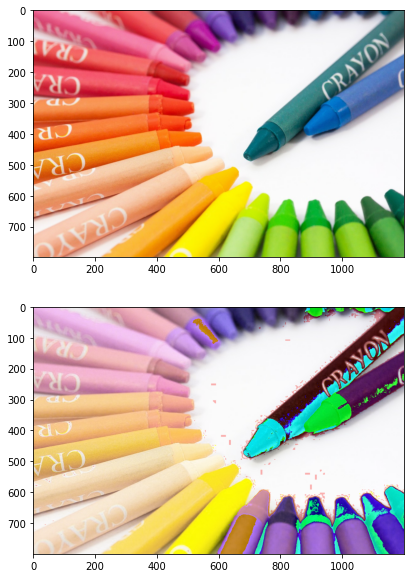

In [ ]:
# USAGE OF LIBRARY

# load image
img1 = cv2.imread("crayons.png")
img1 = img1[..., ::-1]

plt.figure(figsize=(10, 10))

plt.subplot(2,1,1)
plt.imshow(img1.astype('uint8'))

# correct using daltonization
daltonized_img1 = colorblind.daltonize_correct(img1, colorblind_type='p')

plt.subplot(2,1,2)
plt.imshow(daltonized_img1.astype('uint8'))

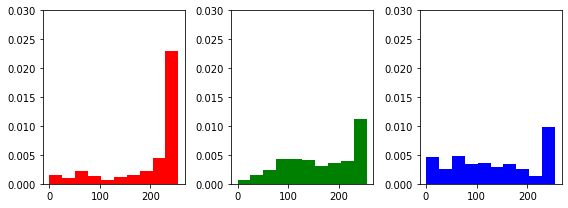

In [ ]:
R = img1[:,:,0]
G = img1[:,:,1]
B = img1[:,:,2]

plt.figure(figsize=(8,3))

plt.subplot(1,3,1)
plt.hist(R.ravel(), density=True, color='r');
plt.ylim([0,0.03])


plt.subplot(1,3,2)
plt.hist(G.ravel(), density=True, color='g');
plt.ylim([0,0.03])

plt.subplot(1,3,3)
plt.ylim([0,0.03])
plt.hist(B.ravel(), density=True, color='b');

plt.tight_layout()

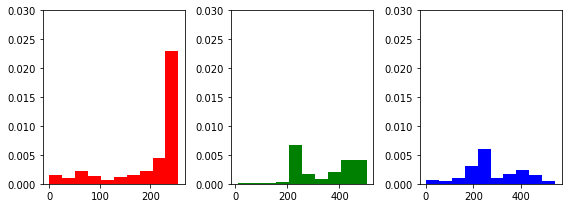

In [ ]:
R = daltonized_img1[:,:,0]
G = daltonized_img1[:,:,1]
B = daltonized_img1[:,:,2]

plt.figure(figsize=(8,3))

plt.subplot(1,3,1)
plt.hist(R.ravel(), density=True, color='r');
plt.ylim([0,0.03])


plt.subplot(1,3,2)
plt.hist(G.ravel(), density=True, color='g');
plt.ylim([0,0.03])

plt.subplot(1,3,3)
plt.ylim([0,0.03])
plt.hist(B.ravel(), density=True, color='b');

plt.tight_layout()

Let's give a closer look at how the library is implemented, and let's try to change the typing of the matrices during the whole operation (without converting with astype(uint8)). Also *changing the tensordot operation with the @ operator applied to the transposed right matrix* can help

In [ ]:
def changeSpaceOld(img, mat):
    return np.tensordot(img, mat, axes=([2], [1]))

def changeSpaceNew(img, mat):
    return img @ mat.T

def rgb_to_lms(img):
    lms_matrix = np.array(
        [[0.3904725 , 0.54990437, 0.00890159],
        [0.07092586, 0.96310739, 0.00135809],
        [0.02314268, 0.12801221, 0.93605194]]
        )
    return changeSpaceNew(img, lms_matrix)

def lms_to_rgb(img):
    rgb_matrix = np.array(
        [[ 2.85831110e+00, -1.62870796e+00, -2.48186967e-02],
        [-2.10434776e-01,  1.15841493e+00,  3.20463334e-04],
        [-4.18895045e-02, -1.18154333e-01,  1.06888657e+00]]
        )
    return changeSpaceNew(img, rgb_matrix)

def simulate_colorblindness(img, colorblind_type):
    #using the RGB-to-LMS matrix, data is transformed into the LMS space.
    lms_img = rgb_to_lms(img)
    #deletion of the information corresponding to one of the cone types
    if colorblind_type.lower() in ['protanopia', 'p', 'pro']:
        sim_matrix = np.array([[0, 0.90822864, 0.008192], [0, 1, 0], [0, 0, 1]], dtype=np.float16)
    elif colorblind_type.lower() in ['deuteranopia', 'd', 'deut']:
        sim_matrix =  np.array([[1, 0, 0], [1.10104433,  0, -0.00901975], [0, 0, 1]], dtype=np.float16)
    elif colorblind_type.lower() in ['tritanopia', 't', 'tri']:
        sim_matrix = np.array([[1, 0, 0], [0, 1, 0], [-0.15773032,  1.19465634, 0]], dtype=np.float16)
    else:
        raise ValueError('{} is an unrecognized colorblindness type.'.format(colorblind_type))
    # matrix multiply
    lms_img = changeSpaceNew(lms_img, sim_matrix)
    # return back to rgb space with inverse transform.
    rgb_img = lms_to_rgb(lms_img)
    # let's save the image as a colorblind person "should" see it
    io.imsave("asColorBlind.jpg",rgb_img)
    # OLD: return rgb_img.astype(np.uint8)
    return rgb_img

In [ ]:
def daltonize_correct(img, colorblind_type):
    colorblind_img = simulate_colorblindness(img, colorblind_type=colorblind_type)
    # error matrix is the difference between the original img and the simulated one
    error_matrix = img - colorblind_img
    # let's save this "error" trace
    io.imsave("errorImg.jpg",error_matrix)
    # correction with linear trans. to convey info to the colorblind person
    # done by mapping to the other side of the spectrum
    correction_matrix = np.array(
            [[0.0, 0.0, 0.0],
            [0.7, 1.0, 0.0],
            [0.7, 0.0, 1.0]]
            )
    # rotates this to a part of the spectrum that they can sees
    corrected_error_matrix = changeSpaceNew(error_matrix, correction_matrix)
    # let's save the highlight mask
    io.imsave("correctedErrorImg.jpg",corrected_error_matrix)
    # add the correction (highlight mask) to the image
    final = img + corrected_error_matrix
    np.set_printoptions(threshold=sys.maxsize)

    # Steps
    nImages = 7
    plt.figure(figsize=(30, 30))
    plt.subplot(1,nImages,1)
    plt.imshow(img)
    for x in range(2,nImages+1):
      img += (corrected_error_matrix / nImages)
      plt.subplot(1,nImages,x)
      plt.imshow(img)

    return final

*Here is a result without data clipping:*

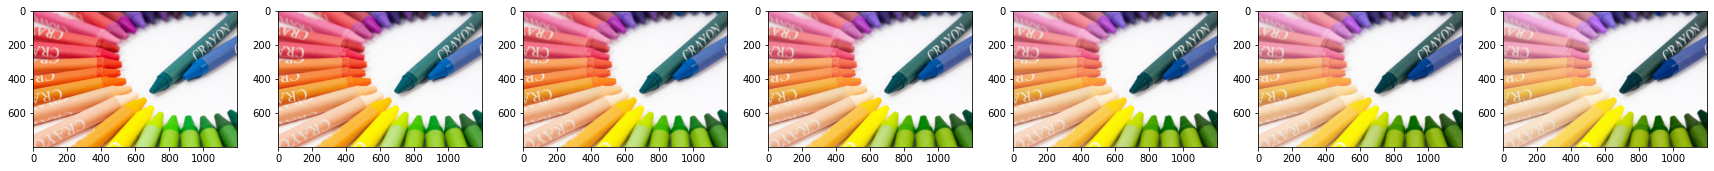

In [ ]:
# load image
img2 = plt.imread("crayons.png")

# correct using daltonization
daltonized_img2 = daltonize_correct(img2, colorblind_type='p')

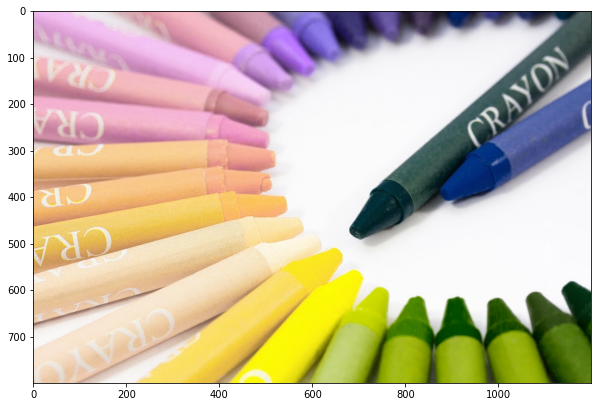

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(daltonized_img2)

### **Commented results**:
We've seen another example of daltonization, this time with a more "natural image". We've explored the modules and we understood how to "play" with types and operations in order to remove the clipping and obtaining a cleaner result

## **Goal 3**:

**From the paper: An Improved Dynamic Daltonization for Color-
Blinds (Anika Tasnim)**


**Department of Electrical and Computer Engineering - North South University: Dhaka, Bangladesh**

An improved algorithm, proposed by that university paper, simulates protanope 
vision of an image (as the first one) -> then it divides the original image into two 
images depending on the color perceptibility of protanope (and here we implement this part, that i couldn't found implemented online) ->
the imperceptible image is then iteratively Daltonized 
depending on the hue similarity of modified image and 
perceptible image. When the two images are different in terms 
of hue the final output is generated. This allows a more natural image as output

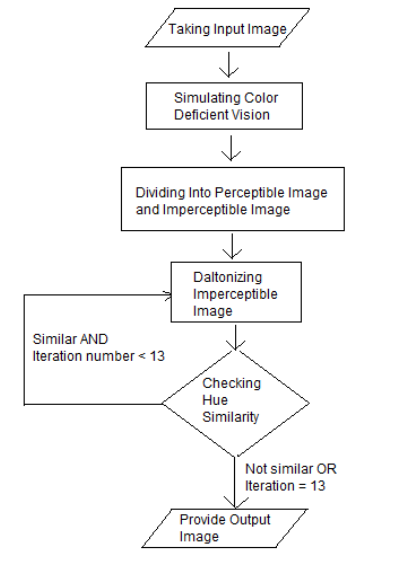

*Let's implement the separatePixels operation in the pipeline*:



This module divides I into two images; Icorrect which contains pixels whose color is perceived correctly by 
protanope and Iincorrect which contains pixels whose color is not 
perceived correctly by protanope.
The algorithm works in this way:

1) In order to categorize the image two binary masks IE and IR are created. An error image E is calculated using:

ER = | R – Rp |, EG = | G – Gp |, EB = | R – Rp |
, with R & G channels from original img and Rp & Gp from the colorblind simulated one.

-----------------

2) Applying image binarization on E with a very low
threshold the first mask IE is obtained. When a pixel in E is
equal or higher than the threshold, the corresponding pixel in
IE is assigned 1 and when it is below the threshold
corresponding IE is assigned 0. "We're giving weight to pixels that partecipates to the error img"

-----------------

3) For achieving the second
mask every pixel of I is scanned. Whenever a pixel’s red
component is higher than green and blue IR is assigned 1.
When the green or blue component is higher, IR is assigned 0. "We're giving weight to pixels that are mostly red in the original img"

-----------------

4) By calculating the intersection of the two masks IE and IR
the final mask Imask is obtained. "We create a mask where the two encounters. So a track of where the problems are"

-----------------

5) Icorrect is generated with a logical AND of inverse Imask and I. "AND with the inverse of the problems"

-----------------

6) Iincorrect is generated with a logical AND between Imask
and I. "AND with the problems"

In [ ]:
def separatePixels(img):
    # generate asColorBlind
    colorblind_img = simulate_colorblindness(img, colorblind_type='p').astype('uint8')
    
    # IN: img (original), colorblind_img (asColorBlind)

    R1 = img[:,:,0]
    G1 = img[:,:,1]
    R2 = colorblind_img[:,:,0]
    G2 = colorblind_img[:,:,1]

    # generate error img E
    E = img
    E[:,:,0] = abs(R1 - R2)
    E[:,:,1] = abs(G1 - G2)
    E[:,:,2] = abs(R1 - R2)

    IE = IR = Imask = np.zeros((np.shape(E[..., 0])))

    # obtain first mask IE with threshold th chosen (low)
    th = 35
    IE = (E[..., 0] >= th) & (E[..., 1] >= th) & (E[..., 2] >= th)
    
    # obtain second mask IR
    IR = (img[..., 0] > img[..., 1]) & (img[..., 0] > img[..., 2])

    # Imask = IE intersect IR
    ImaskInverse = IE ^ IR
    Imask = ~ImaskInverse

    # Iincorrect = mask logicalAND original
    Icorrect = np.zeros(np.shape(img))
    Iincorrect = np.zeros(np.shape(img))
    Icorrect[..., 0] = img[..., 0] * ImaskInverse
    Icorrect[..., 1] = img[..., 1] * ImaskInverse
    Icorrect[..., 2] = img[..., 2] * ImaskInverse
    
    # Icorrect = inverse(mask) logicalAND original 
    Iincorrect[..., 0] = img[..., 0] * Imask
    Iincorrect[..., 1] = img[..., 1] * Imask
    Iincorrect[..., 2] = img[..., 2] * Imask

    return Icorrect, Iincorrect

**Lets' see together some applied examples of this module**

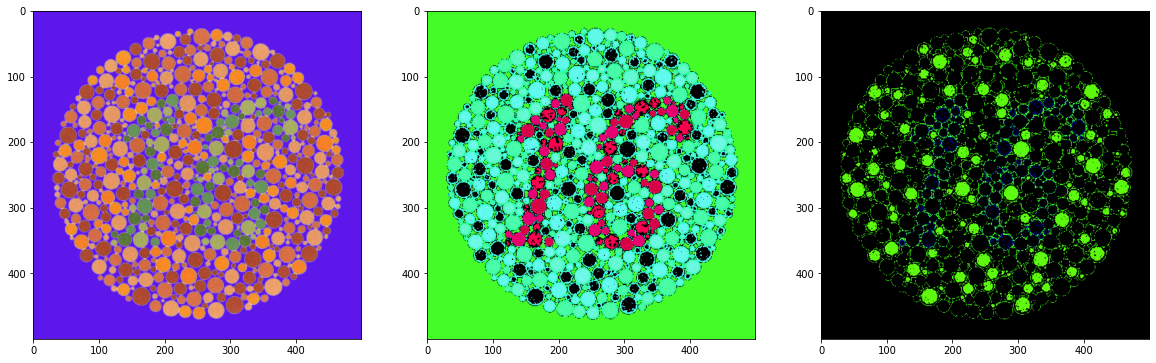

In [ ]:
# load image 1
img = cv2.imread("ishihara2.png")
img = img[..., ::-1]

plt.figure(figsize=(20, 20))

plt.subplot(1,3,1)
plt.imshow(img.astype('uint8'))

Icorrect, Iincorrect = separatePixels(img)

plt.subplot(1,3,2)
plt.imshow(Icorrect.astype('uint8'))

plt.subplot(1,3,3)
plt.imshow(Iincorrect.astype('uint8'))

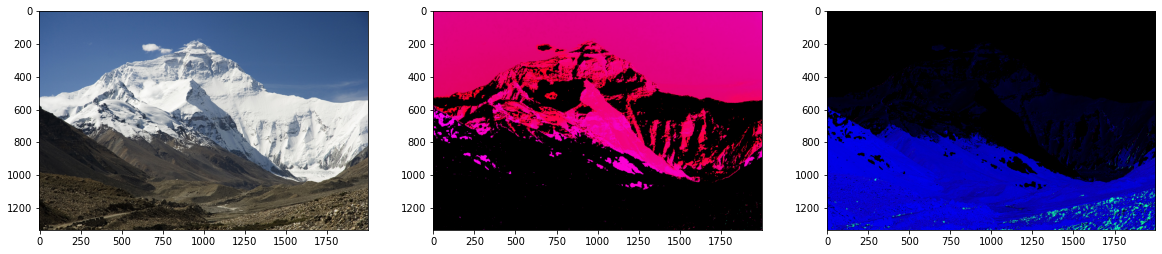

In [ ]:
# load image 2
img = cv2.imread("mountain.jpg")
img = img[:,:, ::-1]

plt.figure(figsize=(20, 20))

plt.subplot(1,3,1)
plt.imshow(img.astype('uint8'))

Icorrect, Iincorrect = separatePixels(img)

plt.subplot(1,3,2)
plt.imshow(Icorrect.astype('uint8'))

plt.subplot(1,3,3)
plt.imshow(Iincorrect.astype('uint8'))

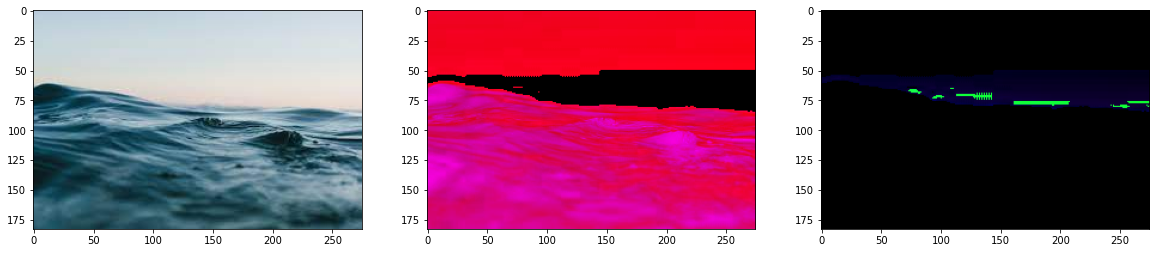

In [ ]:
# load image 3
img = cv2.imread("sea.jpg")
img = img[..., ::-1]

plt.figure(figsize=(20, 20))

plt.subplot(1,3,1)
plt.imshow(img.astype('uint8'))

Icorrect, Iincorrect = separatePixels(img)

plt.subplot(1,3,2)
plt.imshow(Icorrect.astype('uint8'))

plt.subplot(1,3,3)
plt.imshow(Iincorrect.astype('uint8'))

###**Commented results**:
We've commented the improved algorithm for daltonization, understanding at high level how the iterative procedure can help us obtaining more "natural results". Then, most importantly, we've implemented the second operation of the pipeline (starting from the output of the simulate_colorblindness): this function allows us to separate the correctly seen pixels from the wrongly seen ones. We clearly see how the "bad parts" from a protanope point of view are kept in the wrongly seen image (and, viceversa, removed in the correctly seen one)

## **Goal 4**:

Do you remember, in the first Goal, the image that showed how a colorblind person should see the right one?

Well, as a "protanope", i find it exaggerated!

**The problem, as i described it to who implemented the library**: "as a color-blind person i'm noticing a really high difference between the "simulated" image (so the one that should look as i see the original one); so i was asking myself how that difference can be smoothed out"

**The solution: physiological based model**

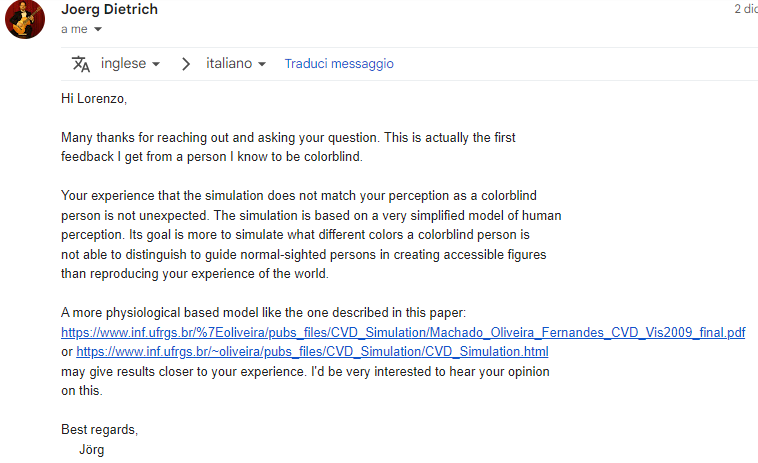

This model is based on the stage theory of human color vision and is derived from data reported in electrophysiological studies. It allows us to convey more information when we consider the daltonization. It's not a coded simulation anymore, but a more detailed model. Instead of "just" shifting the curves corresponding to L,S and M cones, we build a second reflected space. Thanks to this merge we are able, using complex integrals, to express the color deficiency with more detail

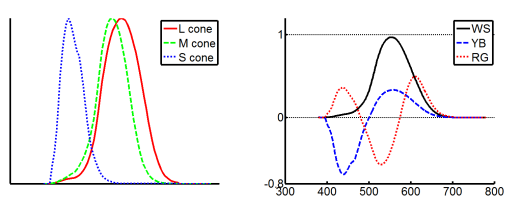

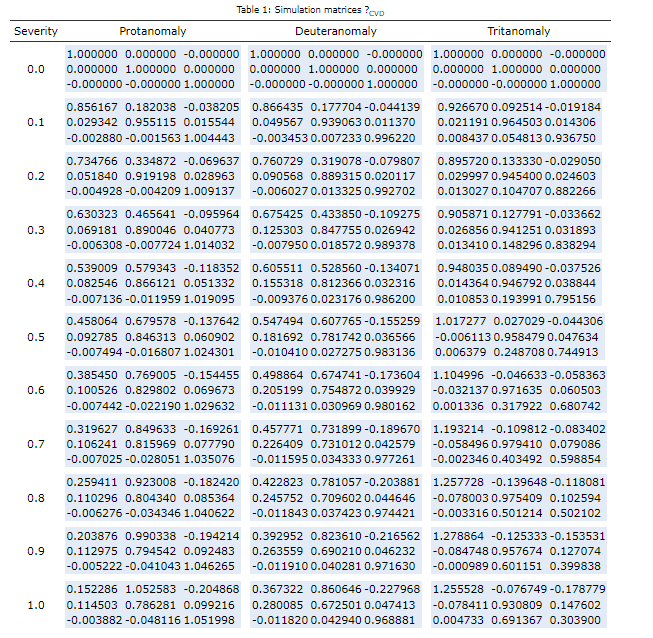

### **Commented results**:
We've briefly explored a more physiological way to see the daltonizing problem, that highlights how the first methods lack in representing the "severity" of the color deficiency (counting it as maximum). Thanks to this study i've understood that i'm not actually a "protanope". I have a medium strong "protanomaly" (around average level 0.6 of severity). So "protanopy" is a "maximum severity protanomaly"

### **EXTRA: "An useful application"**: Let's try to use the library to daltonize a scraped screenshot of a webpage. For this purpose we use Selenium

Ign:1 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done
Building dependency tree       
Reading state infor

<ipython-input-10-5f0b2ced64c1>:6: UserWarning: errorImg.jpg is a low contrast image
  io.imsave("errorImg.jpg",error_matrix)


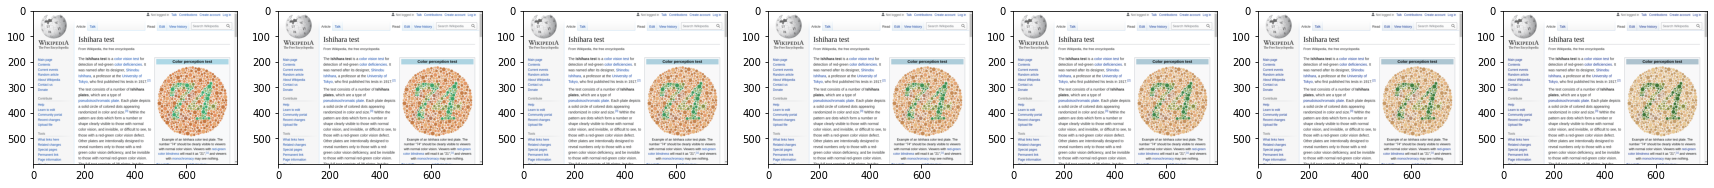

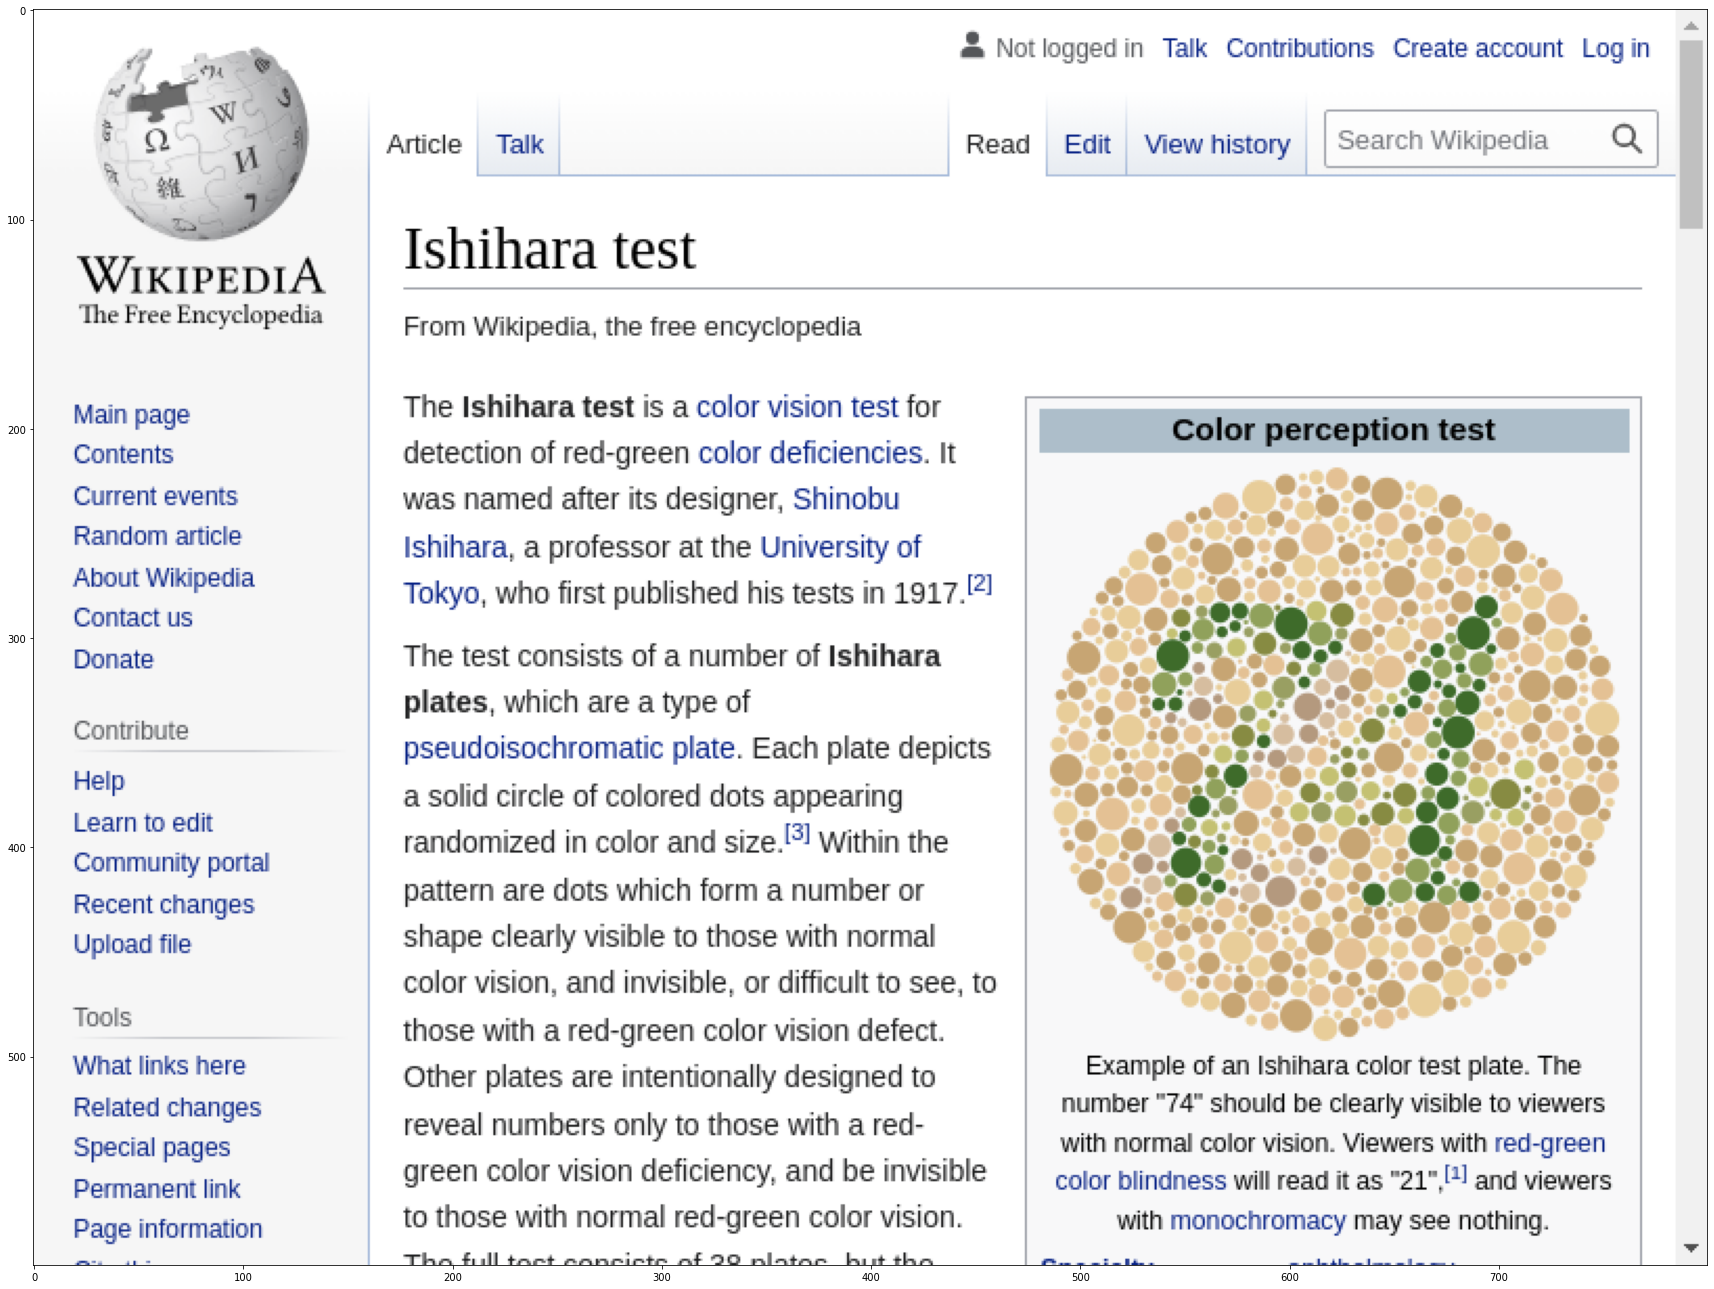

In [ ]:
# install chromium, its driver, and selenium
!apt update
!apt install chromium-chromedriver
!pip install selenium
from selenium import webdriver
# options for chrome driver
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
wd = webdriver.Chrome(options=options)

# let's daltonize unige's homepage
url = "https://en.wikipedia.org/wiki/Ishihara_test"
# Opening the website and saving the screenshot
wd.get(url)
wd.save_screenshot("scrapedImg.png")
image = Image.open("scrapedImg.png")
image.show()

# daltonizing
web = plt.imread("scrapedImg.png")
# Per eliminare il canale 4 png
web = cv2.cvtColor(web, cv2.COLOR_BGRA2BGR)
daltonized_web = daltonize_correct(web, colorblind_type='p')
plt.figure(figsize=(30, 30))
plt.imshow(daltonized_web)